In [1]:
### loading in the libraries 
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

**Heart Disease Report Group 41**

Introduction: 

Heart Disease is a term used to describe many different conditions that affect the heart. The severity of a heart disease can vary greatly in extremity, and curability. Some examples of heart disease include : heart attack,  high blood pressure, stroke, and coronary heart disease. Heart diseases are often genetic, and there are many predictors that can be used by doctors and researchers to identify if a patient is at risk. This has become as relevant as ever, as it is estimated that approximately 17.9 million people in the world die each year from a heart disease. 

The question we want to answer is using cholesterol level, blood pressure, heart rate and age to predict whether a person would have a heart disease.

We are using a database with 13 variables, of which describe information about the 303 patients from Cleveland, Ohio. (For the result for diagnosis of heart disease, 0 means disease is not present while 1-4 means disease is present). Some of the variables include missing values, which are identified from the database site.  The dataset has been referenced in plenty of classification and regression papers.

Preliminary exploratory data analysis:

In [2]:
# URL from github to read the data
url <- "https://raw.githubusercontent.com/GloriaYi/dsci-100-2023w1-group41/main/processed.cleveland.data"

In [3]:
# naming the columns 
col_names <- c("age", "sex", "cp", "resting_blood_pressure", "cholesterol",
               "fasting_blood_sugar", "restecg", "maximum_heart_rate_achieved", 
               "exercise_induced_angina", "ST_depression_induced_by_excercise_relative_to_rest", 
               "slope", "number_of_major_vessels", "thal", "diagnosis_of_heart_disease")

# reading the data
raw_data <- read_csv (url, col_name = col_names)
raw_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): number_of_major_vessels, thal
dbl (12): age, sex, cp, resting_blood_pressure, cholesterol, fasting_blood_s...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,resting_blood_pressure,cholesterol,fasting_blood_sugar,restecg,maximum_heart_rate_achieved,exercise_induced_angina,ST_depression_induced_by_excercise_relative_to_rest,slope,number_of_major_vessels,thal,diagnosis_of_heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


In [4]:
# keeping only the columns we need
keep_data <- raw_data |>
    select (age, resting_blood_pressure, cholesterol, maximum_heart_rate_achieved, diagnosis_of_heart_disease)
keep_data


age,resting_blood_pressure,cholesterol,maximum_heart_rate_achieved,diagnosis_of_heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,145,233,150,0
67,160,286,108,2
67,120,229,129,1
⋮,⋮,⋮,⋮,⋮
57,130,131,115,3
57,130,236,174,1
38,138,175,173,0


In [5]:
# treating diagnosis_of_heart_disease as factor 
heart_disease <- keep_data |>
    mutate (diagnosis_of_heart_disease = as_factor (diagnosis_of_heart_disease))
    

# changing ? to NA
heart_disease[heart_disease == "?"] <- NA

heart_disease

age,resting_blood_pressure,cholesterol,maximum_heart_rate_achieved,diagnosis_of_heart_disease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,0
67,160,286,108,2
67,120,229,129,1
⋮,⋮,⋮,⋮,⋮
57,130,131,115,3
57,130,236,174,1
38,138,175,173,0


In [6]:
# splitting the data into training and testing
heart_disease_split <- initial_split (heart_disease, prop = 0.75, strata = diagnosis_of_heart_disease)
heart_disease_train <- training (heart_disease_split)
heart_disease_test <- testing (heart_disease_split)


In [7]:
# the count of each factor of heart disease
heart_disease_count <- heart_disease_train |>
    group_by (diagnosis_of_heart_disease) |>
    summarize (count = n())

heart_disease_count

# the average of the variables we will be using
heart_disease_averages <- heart_disease_train |>
  select(age: maximum_heart_rate_achieved) |>
  map_dfr(mean)

heart_disease_averages




diagnosis_of_heart_disease,count
<fct>,<int>
0,122
1,42
2,26
3,26
4,9


age,resting_blood_pressure,cholesterol,maximum_heart_rate_achieved
<dbl>,<dbl>,<dbl>,<dbl>
54.08444,131.5822,243.9289,149.6533


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


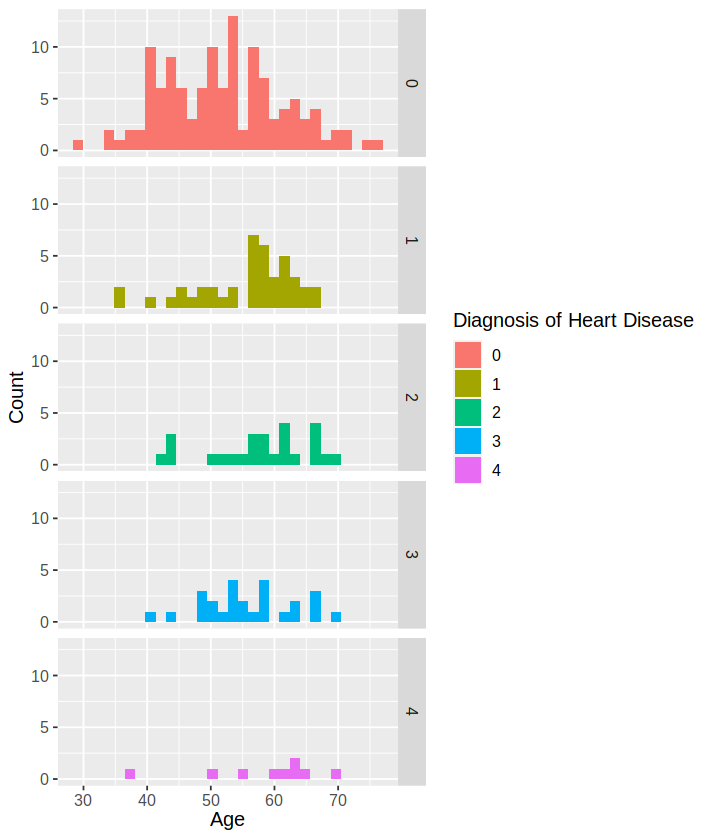

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


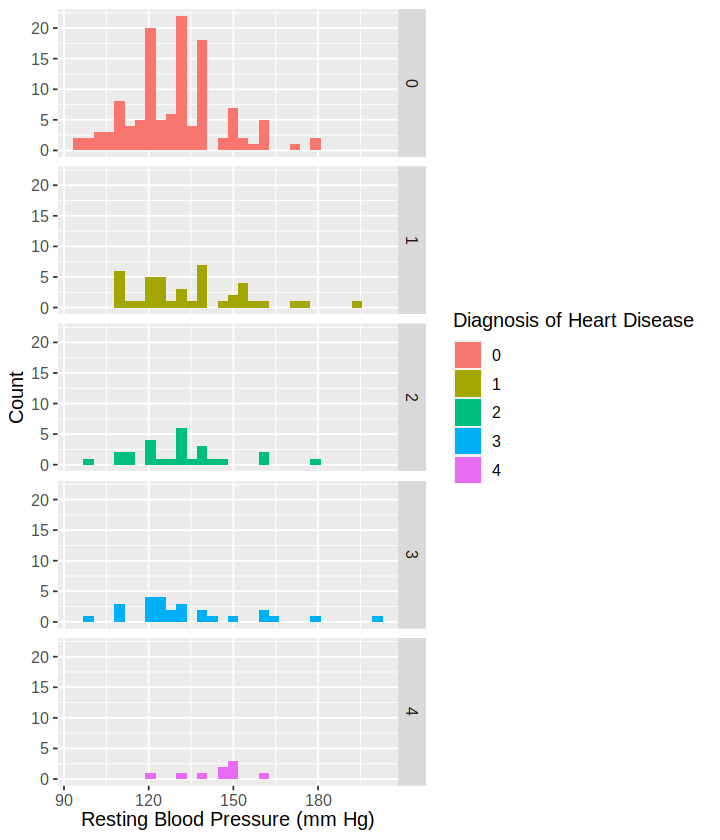

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


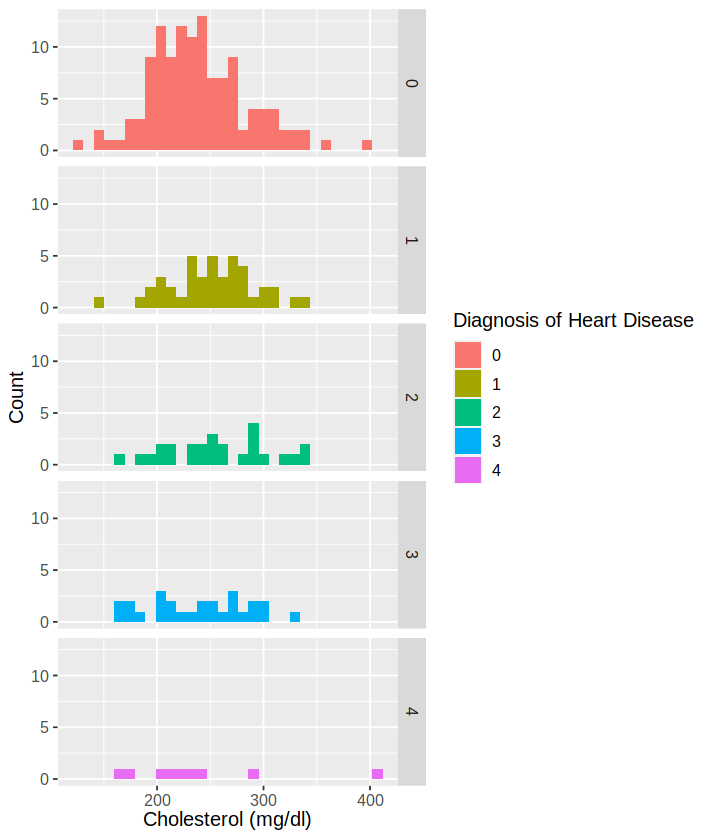

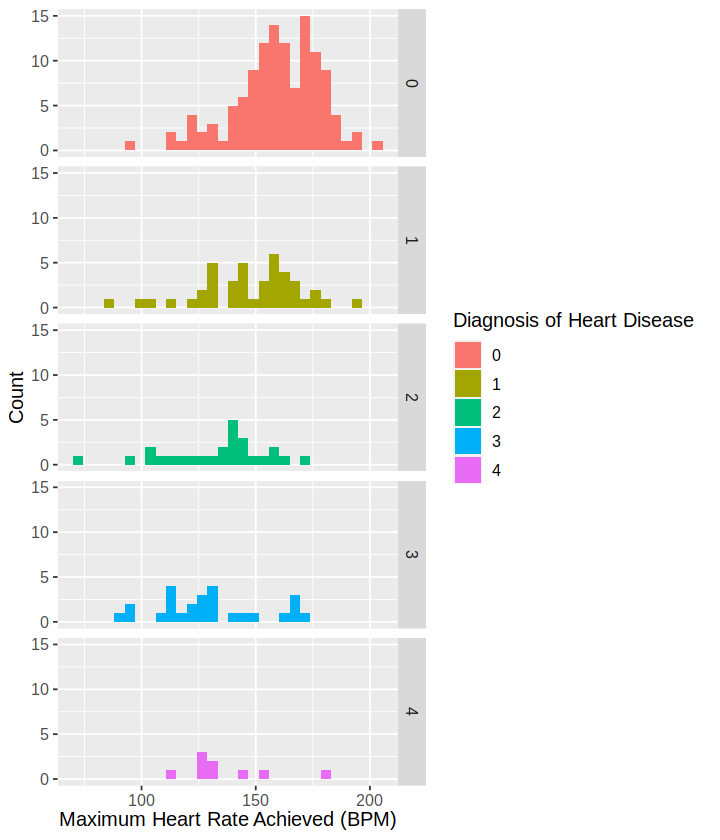

In [8]:
# visualizing the data 
options(repr.plot.width = 6, repr.plot.height = 7)

heart_disease_age <- heart_disease_train |>
    ggplot (aes (x = age, fill = as_factor(diagnosis_of_heart_disease))) +
  geom_histogram() +
  facet_grid(rows = vars(diagnosis_of_heart_disease)) +
    labs(x = "Age", 
       y = "Count", 
       fill = "Diagnosis of Heart Disease") +
  theme(text = element_text(size = 12))

heart_disease_age

heart_disease_resting_blood_pressure <- heart_disease_train |>
    ggplot (aes (x = resting_blood_pressure, fill = as_factor(diagnosis_of_heart_disease))) +
  geom_histogram() +
  facet_grid(rows = vars(diagnosis_of_heart_disease)) +
    labs(x = "Resting Blood Pressure (mm Hg)", 
       y = "Count", 
       fill = "Diagnosis of Heart Disease") +
  theme(text = element_text(size = 12))

heart_disease_resting_blood_pressure

heart_disease_cholesterol <- heart_disease_train |>
    ggplot (aes (x = cholesterol, fill = as_factor(diagnosis_of_heart_disease))) +
  geom_histogram() +
  facet_grid(rows = vars(diagnosis_of_heart_disease)) +
    labs(x = "Cholesterol (mg/dl)", 
       y = "Count", 
       fill = "Diagnosis of Heart Disease") +
  theme(text = element_text(size = 12))

heart_disease_cholesterol

heart_disease_maximum_heart_rate_achieved <- heart_disease_train |>
    ggplot (aes (x = maximum_heart_rate_achieved, fill = as_factor(diagnosis_of_heart_disease))) +
  geom_histogram() +
  facet_grid(rows = vars(diagnosis_of_heart_disease)) +
    labs(x = "Maximum Heart Rate Achieved (BPM)", 
       y = "Count", 
       fill = "Diagnosis of Heart Disease") +
  theme(text = element_text(size = 12))

heart_disease_maximum_heart_rate_achieved

Methods: 

We will be using 4 columns for our data analysis cholesterol, resting blood pressure, maximum heart rate achieved and age, as these are strong determiners in an individuals risk for heart disease, according to the CDC. To conduct our data analysis using the split training and testing data after scaling the subsets, we will use cross validation with a fold of five to determine which k value is the most optimal based on it's accuracy. After that we will use the k nearest neighbors method to predict the classification of a new observation - if the patient has heart disease. 

Expected outcomes and significance:

We expect to see patients that are high in blood pressure / cholesterol level / age / heart rate have a higher risk of getting heart disease. We also want to examine how well our classifier works on predicting if the patient would have heart disease. If the classifier could understand the relationship between the predictors and the heart disease diagnosis well enough, we could get a more accurate result for prediction. This might be beneficial to patients at risk of potential heart disease because their condition might not be as severe if intervened early. The attempt with using k-nearest neighbors algorithm to do prediction acts as a foundation to explore classification. Some future question might be: whether all these variables contribute equally in prediction of presence of heart disease? Is there a better model than knn for prediction?